In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib import colors
from copy import deepcopy

%matplotlib inline

# Read data

## Rashomon

In [127]:
# fname_csv = "../Results/reff_simulations_rashomon_25_100.csv"
# fname_csv = "../Results/reff_simulations_rashomon_25_100.csv"
# fname_csv = "../Results/reff_simulations_var_1_rashomon_10_100.csv"
fname_prefix = "reff_simulations_6_"
fname_suffix = "_30_50.csv"
lasso_fname_suffix = "_30_100.csv"
rashomon_fname_csv = "../Results/" + fname_prefix + "rashomon" + fname_suffix
rashomon_raw_df = pd.read_csv(rashomon_fname_csv)
rashomon_raw_df = rashomon_raw_df.drop("Unnamed: 0", axis=1)

# rashomon_raw_df.head()

rashomon_df = rashomon_raw_df.copy()

# compute the loss
reg = 1e-1
rashomon_df["loss"] = rashomon_df["MSE"] + reg * rashomon_df["num_pools"]

# Find whether each model identifies the true best profile or not
true_best_profile = "(1, 0, 1)"
rashomon_df["right_best_profile"] = rashomon_df[true_best_profile]
rashomon_df["wrong_best_profile"] = 1 - rashomon_df["right_best_profile"]

# Remove all other columns
to_drop = ["num_pools", "MSE", "IOU", "min_dosage", "best_pol_diff"]
profile_cols = ["(0, 0, 0)", "(0, 0, 1)", "(0, 1, 0)", "(0, 1, 1)",
                "(1, 0, 0)", "(1, 0, 1)", "(1, 1, 0)", "(1, 1, 1)"]
rashomon_df = rashomon_df.drop(to_drop, axis=1)
# rashomon_df = rashomon_df.drop(profile_cols, axis=1)

# Sort loss grouped by n_per_pol and sim_num
rashomon_df = rashomon_df.sort_values(["n_per_pol", "sim_num", "loss"], ascending=True)

# Count models within each simulation iteration
# Check if best profile is present in the first n models
grouped_df = rashomon_df.groupby(["n_per_pol", "sim_num"]).cumsum()
rashomon_df["best_profile_present"] = (grouped_df["right_best_profile"] > 0).astype(int)
rashomon_df["model_number"] = grouped_df["right_best_profile"] + grouped_df["wrong_best_profile"]

print(len(rashomon_df))

rashomon_df.head(n=10)

215454


,n_per_pol,sim_num,"(0, 0, 0)","(0, 0, 1)","(0, 1, 0)","(0, 1, 1)","(1, 0, 0)","(1, 0, 1)","(1, 1, 0)","(1, 1, 1)",loss,right_best_profile,wrong_best_profile,best_profile_present,model_number
0,30,0,0,0,1,0,0,0,0,0,2.695771,0,1,0,1
80,30,0,0,0,1,0,0,0,0,0,2.728557,0,1,0,2
704,30,0,0,0,1,0,0,0,0,0,2.738788,0,1,0,3
120,30,0,0,0,1,0,0,0,0,0,2.738974,0,1,0,4
160,30,0,0,0,1,0,0,0,0,0,2.739203,0,1,0,5
327,30,0,0,0,1,0,0,0,0,0,2.741030,0,1,0,6
1066,30,0,0,0,1,0,0,0,0,0,2.750776,0,1,0,7
2782,30,0,0,0,1,0,0,0,0,0,2.755869,0,1,0,8
744,30,0,0,0,1,0,0,0,0,0,2.771575,0,1,0,9
367,30,0,0,0,1,0,0,0,0,0,2.773817,0,1,0,10


In [128]:
sims_failing = pd.unique(rashomon_df[rashomon_df["best_profile_present"] == 0]["sim_num"])
never_reaching = []
for sim in sims_failing:
    if 1 not in pd.unique(rashomon_df[rashomon_df["sim_num"] == sim]["(1, 0, 1)"]):
        never_reaching.append(sim)

print(never_reaching)
# for sim in never_reaching:
#     print(rashomon_df[rashomon_df["sim_num"] == sim]["loss"])

[42]


### Epsilon levels

## Lasso

In [129]:
lasso_fname_csv = "../Results/" + fname_prefix + "lasso" + lasso_fname_suffix
lasso_raw_df = pd.read_csv(lasso_fname_csv)
lasso_raw_df = lasso_raw_df.drop("Unnamed: 0", axis=1)

# lasso_raw_df.head()

lasso_df = lasso_raw_df.copy()

# Find whether each model identifies the true best profile or not
true_best_profile = "(1, 0, 1)"
lasso_df["right_best_profile"] = lasso_df[true_best_profile]
lasso_df["wrong_best_profile"] = 1 - lasso_df["right_best_profile"]

# Remove all other columns
to_drop = ["MSE", "IOU", "min_dosage", "best_pol_diff"]
profile_cols = ["(0, 0, 0)", "(0, 0, 1)", "(0, 1, 0)", "(0, 1, 1)",
                "(1, 0, 0)", "(1, 0, 1)", "(1, 1, 0)", "(1, 1, 1)"]
lasso_df = lasso_df.drop(to_drop, axis=1)

# Sort loss grouped by n_per_pol and sim_num
lasso_df = lasso_df.sort_values(["n_per_pol", "sim_num", "L1_loss"], ascending=True)

# Count models within each simulation iteration
# Check if best profile is present in the first n models
grouped_df = lasso_df.groupby(["n_per_pol", "sim_num"]).cumsum()
lasso_df["best_profile_present"] = (grouped_df["right_best_profile"] > 0).astype(int)
# lasso_df["model_number"] = grouped_df["right_best_profile"] + grouped_df["wrong_best_profile"]

print(len(lasso_df))

lasso_df.head(n=10)

100


,n_per_pol,sim_num,L1_loss,"(0, 0, 0)","(0, 0, 1)","(0, 1, 0)","(0, 1, 1)","(1, 0, 0)","(1, 0, 1)","(1, 1, 0)","(1, 1, 1)",right_best_profile,wrong_best_profile,best_profile_present
0,30,0,2.879195,0,0,1,0,0,0,0,0,0,1,0
1,30,1,2.818417,0,0,0,1,0,0,0,0,0,1,0
2,30,2,2.902470,0,0,0,0,0,1,0,0,1,0,1
3,30,3,2.818496,0,0,1,0,0,0,0,0,0,1,0
4,30,4,2.885933,0,0,1,0,0,0,0,0,0,1,0
5,30,5,2.881958,0,0,0,0,1,0,0,0,0,1,0
6,30,6,2.841328,0,0,0,0,0,1,0,0,1,0,1
7,30,7,3.166266,0,0,1,0,0,0,0,0,0,1,0
8,30,8,2.817998,0,0,0,0,0,1,0,0,1,0,1
9,30,9,2.869286,0,0,0,0,1,0,0,0,0,1,0


## Causal Trees

In [130]:
# ct_fname_csv = "../Results/" + fname_prefix + "ct" + fname_suffix
# ct_raw_df = pd.read_csv(ct_fname_csv)
# ct_raw_df = ct_raw_df.drop("Unnamed: 0", axis=1)

# # lasso_raw_df.head()

# ct_df = ct_raw_df.copy()

# # Find whether each model identifies the true best profile or not
# true_best_profile = "(1, 0, 1)"
# ct_df["right_best_profile"] = ct_df[true_best_profile]
# ct_df["wrong_best_profile"] = 1 - ct_df["right_best_profile"]

# # Remove all other columns
# to_drop = ["IOU", "min_dosage", "best_pol_diff"]
# profile_cols = ["(0, 0, 0)", "(0, 0, 1)", "(0, 1, 0)", "(0, 1, 1)",
#                 "(1, 0, 0)", "(1, 0, 1)", "(1, 1, 0)", "(1, 1, 1)"]
# ct_df = ct_df.drop(to_drop, axis=1)

# # Sort loss grouped by n_per_pol and sim_num
# ct_df = ct_df.sort_values(["n_per_pol", "sim_num", "MSE"], ascending=True)

# # Count models within each simulation iteration
# # Check if best profile is present in the first n models
# grouped_df = ct_df.groupby(["n_per_pol", "sim_num"]).cumsum()
# ct_df["best_profile_present"] = (grouped_df["right_best_profile"] > 0).astype(int)
# # lasso_df["model_number"] = grouped_df["right_best_profile"] + grouped_df["wrong_best_profile"]

# print(len(ct_df))

# ct_df.head(n=10)

## Bar plot

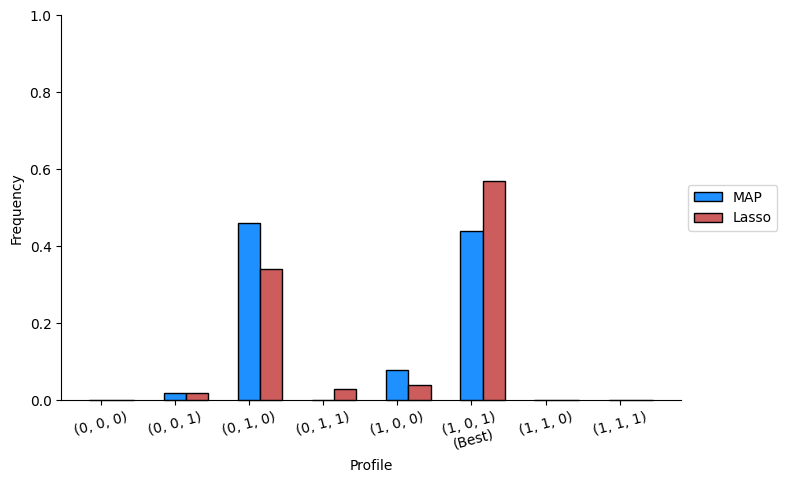

In [131]:
best_models_df = rashomon_df[rashomon_df["model_number"] == 1]

rashomon_profile_means = []
lasso_profile_means = []
ct_profile_means = []
for profile in profile_cols:
    profile_mean_col = profile + "_mean"
    rashomon_profile_means.append(np.mean(best_models_df[profile]))
    lasso_profile_means.append(np.mean(lasso_df[profile]))
    ct_profile_means.append(np.mean(ct_df[profile]))

fig, ax = plt.subplots(figsize=(8,5))

ax.spines[['right', 'top']].set_visible(False)
profile_col_labels = deepcopy(profile_cols)
profile_col_labels[-3] = profile_cols[-3] + "\n(Best)"
ax.set_xticks(np.arange(len(profile_cols)), profile_col_labels, rotation=15)
ax.set_ylim(0, 1)

width = 0.3

ax.bar(np.arange(len(profile_cols)), rashomon_profile_means, width,
           color="dodgerblue", edgecolor="black", zorder=3, clip_on=False,
           label="MAP"
          )

ax.bar(np.arange(len(profile_cols)) + width, lasso_profile_means, width,
           color="indianred", edgecolor="black", zorder=3, clip_on=False,
           label="Lasso"
          )

# ax.bar(np.arange(len(profile_cols)) - width, ct_profile_means, width,
#            color="forestgreen", edgecolor="black", zorder=3, clip_on=False,
#            label="Causal Trees"
#           )

ax.set_xlabel("Profile")
ax.set_ylabel("Frequency")
# ax.set_title("Best model")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

plt.show()

In [132]:
print("Rashomon\t", rashomon_profile_means)
print("Lasso\t\t", lasso_profile_means)

Rashomon	 [0.0, 0.02, 0.46, 0.0, 0.08, 0.44, 0.0, 0.0]
Lasso		 [0.0, 0.02, 0.34, 0.03, 0.04, 0.57, 0.0, 0.0]


## Epsilon plot

In [141]:
eps_df = rashomon_df.copy()

eps_df = eps_df.drop(profile_cols, axis=1)

eps_df["eps"] = eps_df.groupby(["n_per_pol", "sim_num"])["loss"].transform(lambda x: (x - x.min()) / x.min() * 100)

# eps_levels = [-0.1, 0, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 6]
# eps_levels = [-0.1, 0, 3, 5, 7, 9, 11]
# eps_levels = [-0.1, 0, 5.2, 5.4, 5.6, 5.8, 6, 11, 12]

eps_hist = np.histogram(eps_df["eps"], bins=15)[1].tolist()
eps_levels = [-0.1] + eps_hist + [np.max(eps_df["eps"]) + 0.1]
# eps_levels = [-0.1 + np.min(eps_hist)] + eps_hist + [np.max(eps_hist) + 0.1]
eps_bins = eps_levels[1:]
eps_df["eps_levels"] = pd.cut(eps_df["eps"], bins=eps_levels, labels=eps_bins)

eps_df.head()

,n_per_pol,sim_num,loss,right_best_profile,wrong_best_profile,best_profile_present,model_number,eps,eps_levels
0,30,0,2.695771,0,1,0,1,0.000000,0.000000
80,30,0,2.728557,0,1,0,2,1.216226,2.003705
704,30,0,2.738788,0,1,0,3,1.595735,2.003705
120,30,0,2.738974,0,1,0,4,1.602627,2.003705
160,30,0,2.739203,0,1,0,5,1.611131,2.003705


In [142]:
print(np.histogram(rashomon_df["loss"])[1].tolist())
print(eps_levels)
print("\n\n")
print("eps:", np.min(eps_df.groupby(["n_per_pol", "sim_num"])["eps"].transform("max")))

for sim in never_reaching:
    print(sim, np.max(eps_df[eps_df["sim_num"] == sim]["eps"]))

[2.60806255302467, 2.647256265177858, 2.686449977331046, 2.7256436894842344, 2.7648374016374224, 2.8040311137906104, 2.8432248259437984, 2.8824185380969864, 2.921612250250175, 2.960805962403363, 2.999999674556551]
[-0.1, 0.0, 1.0018525042190554, 2.0037050084381107, 3.005557512657166, 4.0074100168762214, 5.009262521095277, 6.011115025314332, 7.0129675295333875, 8.014820033752443, 9.016672537971498, 10.018525042190554, 11.020377546409609, 12.022230050628664, 13.02408255484772, 14.025935059066775, 15.02778756328583, 15.12778756328583]



eps: 7.447939732492574
42 13.913545302125119


In [143]:
# eps_df["best_prof_max"] = eps_df.groupby(["n_per_pol", "sim_num", "eps_levels"], observed=False)["best_profile_present"].transform("max")

# eps_df = eps_df.drop_duplicates(["n_per_pol", "sim_num", "eps_levels", "best_prof_max"])

# eps_df["profile_rate_eps"] = eps_df.groupby(
#     ["n_per_pol", "eps_levels"], observed=False)["best_prof_max"].transform("mean")

eps_df["profile_rate_eps"] = eps_df.groupby(
    ["n_per_pol", "eps_levels"], observed=False)["best_profile_present"].transform("mean")


eps_df = eps_df.drop_duplicates(["n_per_pol", "eps_levels"])
eps_df = eps_df.drop(["sim_num", "loss", "right_best_profile", "wrong_best_profile", "best_profile_present"], axis=1)

eps_df = eps_df.sort_values("eps_levels")

eps_df

,n_per_pol,model_number,eps,eps_levels,profile_rate_eps
0,30,1,0.000000,0.000000,0.440000
4684,30,2,0.670697,1.001853,0.776119
80,30,2,1.216226,2.003705,0.644898
1066,30,7,2.040448,3.005558,0.784841
755,30,11,3.198362,4.007410,0.741012
2395,30,44,4.073922,5.009263,0.820057
3188,30,72,5.041327,6.011115,0.802067
2593,30,195,6.114371,7.012968,0.872756
241,30,358,7.013606,8.014820,0.884465
1447,30,696,8.068385,9.016673,0.921746


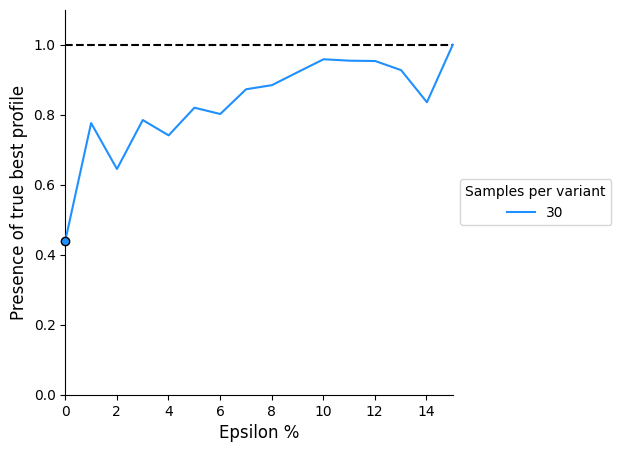

In [146]:
fig, ax = plt.subplots(figsize=(5,5))

ax.spines[['right', 'top']].set_visible(False)

# sizes = [5, 10, 25, 50, 100, 250, 500, 1000]
sizes = [25]
n = 30
colors = ["dodgerblue", "indianred", "green", "orange", "orchid", "mediumseagreen", "slateblue", "slategray"]

len_x = 10
x_horizontal = np.linspace(0, np.max(eps_df["eps_levels"]), num=len_x)
y_best = np.array([1] * len_x)
# y_baseline = np.array([1/8] * len_x)
ax.plot(x_horizontal, y_best, color="black", ls="--")
# ax.plot(x_horizontal, x_horizontal / 2**24, color="grey", ls="--")

# for idx, n in enumerate(sizes):
#     n_subset = eps_df[eps_df["n_per_pol"] == n]
    
ax.plot(eps_df["eps_levels"], eps_df["profile_rate_eps"],
        color=colors[0], zorder=3.1, clip_on=False,
        label=f"{n}")
ax.scatter(eps_df["eps_levels"].iloc[0], eps_df["profile_rate_eps"].iloc[0],
           color=colors[0], edgecolor="black",
           zorder=3.1, clip_on=False)

# ax.set_xscale("log")
ax.set_xlabel("Epsilon %", fontsize=12)
ax.set_ylim(0, 1.1)
ax.set_xlim(0, np.max(eps_df["eps_levels"]))
ax.set_ylabel("Presence of true best profile", fontsize=12)

ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), title="Samples per variant")

# plt.savefig("../Figures/sim_4/true_best_prof.png", dpi=300, bbox_inches="tight")
plt.show()